# Project Part II: Neural Dependency Parsing

Luca D'Este, Alberto Gobbin

# Libraries installation

In [ ]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset
import time
import gc

In [ ]:
# Set up for using Weights & Biases logging platform
wandb_logging = False;
if wandb_logging:
  !pip install wandb
  import wandb
  wandb.login()

# Arc-Eager Algorithm Definition

We present the Arc-Eager dependency parser as described in the paper by Goldberg and Nivre ["A Dynamic Oracle for Arc-Eager
Dependency Parsing"](https://aclanthology.org/C12-1059):

$\begin{array}{lll}
\text{Transition} &  & \text{Precondition} \\
\text{LEFT-ARC}_{l} & (\sigma|i,j|β,A) ⇒ (σ,j|β,A\cup\{(j,l,i)\}) & ¬[i=0]∧¬∃k∃l'[(k,l',i)\in A] \\
\text{RIGHT-ARC}_{l} & (\sigma|i,j|β,A) ⇒ (σ|i|j,β,A\cup\{(j,l,i)\}) \\
\text{REDUCE} & (\sigma|i,β,A) ⇒ (\sigma,\beta,A) & ∃k∃l[(k,l,i)\in A] \\
\text{SHIFT} & (\sigma,i|β,A) ⇒ (\sigma|i,\beta,A) \\
\end{array}$



In [ ]:
class ArcEager:
    def __init__(self, sentence):
        self.sentence = sentence
        self.buffer = [i for i in range(len(self.sentence))]
        self.stack = []
        self.arcs = [-1 for _ in range(len(self.sentence))]

        # Initialize the stack with the first word from the buffer
        self.shift()

    def shift(self):
        b1 = self.buffer[0]
        self.buffer = self.buffer[1:]
        self.stack.append(b1)

    def left_arc(self):
        o1 = self.stack.pop()
        o2 = self.buffer[0]
        self.arcs[o1] = o2

    def right_arc(self):
        o1 = self.stack[len(self.stack) - 1]
        o2 = self.buffer[0]
        self.arcs[o2] = o1
        self.shift()

    def reduce(self):
        self.stack.pop()

    def is_tree_final(self):
        return len(self.stack) == 1 and len(self.buffer) == 0

    def print_configuration(self):
        s = [self.sentence[i] for i in self.stack]
        b = [self.sentence[i] for i in self.buffer]
        print(s, b)
        print(self.arcs)

Then, we define the static oracle algorithm for the Arc-Eager parser, again from Goldberg and Nivre: \\

> $\texttt{if} \ c=(\sigma|i,j|\beta,A) \ \texttt{and} \ (j,l,i)∈A_{gold} \ \texttt{then} \ t \leftarrow \text{LEFT-ARC}_{l}$

> $\texttt{else if} \ c=(\sigma|i,j|\beta,A) \ \texttt{and} \ (i,l,j)∈A_{gold} \ \texttt{then} \ t \leftarrow \text{RIGHT-ARC}_{l}$

> $\texttt{else if} \ c=(\sigma|i,j|\beta,A) \ \texttt{and} \ ∃k[k<i ∧ ∃l[(k,l,j) \in A_{gold} ∨ (j,l,k) ∈ A_{gold}]] \ \texttt{then} \ t ← \text{REDUCE}$

> $ \texttt{else} \ t ← \text{SHIFT}$

> $\texttt{return} \ t$





In [ ]:
class Oracle:
    def __init__(self, parser, gold_tree):
        self.parser = parser
        self.gold = gold_tree

    def is_left_arc_gold(self):
        if len(self.parser.buffer) > 0 and self.parser.stack[len(self.parser.stack) - 1] != 0 and self.parser.arcs[self.parser.stack[len(self.parser.stack) - 1]] == -1:
            o1 = self.parser.stack[len(self.parser.stack) - 1]
            o2 = self.parser.buffer[0]
            if self.gold[o1] == o2:
                return True
        return False

    def is_right_arc_gold(self):
        if len(self.parser.buffer) > 0:
            o1 = self.parser.stack[len(self.parser.stack) - 1]
            o2 = self.parser.buffer[0]
            if self.gold[o2] == o1:
                return True
        return False

    def is_reduce_gold(self):
         if self.parser.stack[len(self.parser.stack) - 1] != 0:
             i = self.parser.stack[len(self.parser.stack) - 1]
             if len(self.parser.buffer) > 0:
                 j = self.parser.buffer[0]
                 # Check if there is a word k < i which is a head of j or a dependent of j in the gold tree
                 for k in range(i):
                     if self.gold[k] == j or self.gold[j] == k:
                         return True
             else:
                 # if buffer is empty, check if i has a head
                 for k in range(i):
                     if self.gold[i] == k:
                         return True
         return False

    def is_shift_gold(self):
        if len(self.parser.buffer) == 0:
          return False

        if self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold():
          return False

        return True

We test of the parser with a single sentence:

In [ ]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

parser.print_configuration()

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [ ]:
while not parser.is_tree_final():
  if oracle.is_left_arc_gold():
    parser.left_arc()
  elif oracle.is_right_arc_gold():
    parser.right_arc()
  elif oracle.is_reduce_gold():
    parser.reduce()
  elif oracle.is_shift_gold():
    parser.shift()

print(parser.arcs)
print(gold)

[-1, 2, 0, 4, 2, 4, 2]
[-1, 2, 0, 4, 2, 4, 2]


At this point, we need a function to remove non-projective trees and a function to create a dictionary with the embedding vocabulary:

In [ ]:
def is_projective(input_tree):
    tree_length = len(input_tree)

    for index in range(tree_length):
        if input_tree[index] == -1:
            continue

        left_node = min(index, input_tree[index])
        right_node = max(index, input_tree[index])

        for node in range(0, left_node):
            if left_node < input_tree[node] < right_node:
                return False

        for node in range(left_node+1, right_node):
            if input_tree[node] < left_node or input_tree[node] > right_node:
                return False

        for node in range(right_node+1, tree_length):
            if left_node < input_tree[node] < right_node:
                return False

    return True

# The function creates a dictionary of word/index pairs: our embeddings vocabulary
def create_dict(dataset, threshold=3):
    dic = {}  # dictionary of word counts
    for sample in dataset:
      for word in sample['tokens']:
        if word in dic:
          dic[word] += 1
        else:
          dic[word] = 1

    map = {}  # dictionary of word/index pairs. This is our embedding list
    map["<pad>"] = 0
    map["<ROOT>"] = 1
    map["<unk>"] = 2 # used for words that do not appear in our list

    next_indx = 3
    for word in dic.keys():
      if dic[word] >= threshold:
        map[word] = next_indx
        next_indx += 1

    return map

Functions to process data to get usable samples and division in batches

In [ ]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  #initialize
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift, 3 reduce

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0) # 0 left gold
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)


  return enc_sentence, gold_path, gold_moves, gold


def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

# Dataset Analysis

We used the [UD English EWT dataset](https://universaldependencies.org/treebanks/en_ewt/index.html).
The dataset consists of several thousand English sentences which have been annotated to parse the syntactic relationships within each sentence. These annotations feature: parts of speech tags, morphological features, and syntactic dependencies.

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_ewt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_ewt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_ewt', split="test")

print("Number of samples:")
print("Train:\t", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

print(train_dataset[1].keys())

# remove sentences with null 'head' values
train_dataset = [sample for sample in train_dataset if 'None' not in sample["head"]]
dev_dataset = [sample for sample in dev_dataset if 'None' not in sample["head"]]
test_dataset = [sample for sample in test_dataset if 'None' not in sample["head"]]

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples after removing null values in head:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_ewt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


Number of samples:
Train:	 12543
Dev:	 2002
Test:	 2077
dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])
Number of samples after removing null values in head:
Train:	 9966
Dev:	 1722
Test:	 1790


In [ ]:
# we look into the second sentence in the dataset and print its tokens and (gold) dependency tree
print(train_dataset[1]["tokens"])
print(train_dataset[1]["head"])
#upos universial part of speech

['[', 'This', 'killing', 'of', 'a', 'respected', 'cleric', 'will', 'be', 'causing', 'us', 'trouble', 'for', 'years', 'to', 'come', '.', ']']
['10', '3', '10', '7', '7', '7', '3', '10', '10', '0', '10', '10', '14', '10', '16', '14', '10', '10']


Plot of sentence length distributions in the datasets

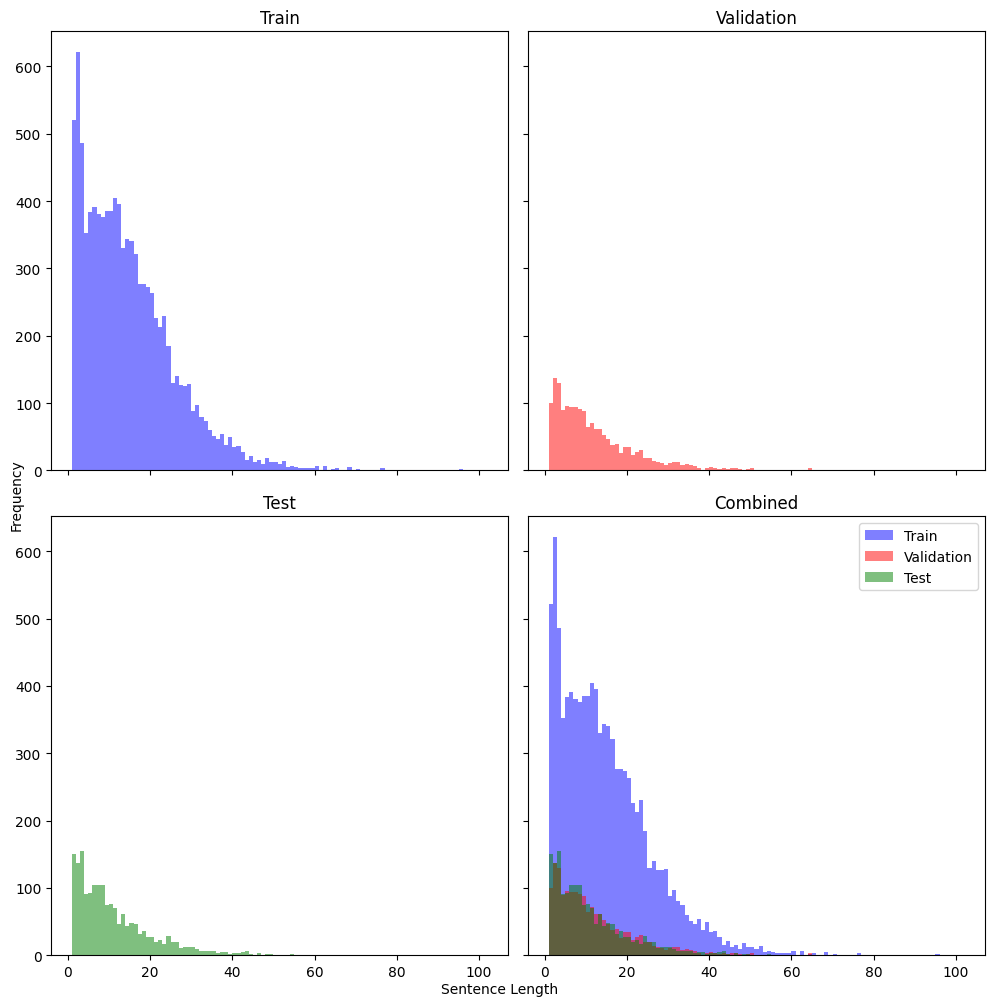

In [ ]:
import matplotlib.pyplot as plt

# Get the lengths of sentences in the training dataset
train_lengths = [len(sample["tokens"]) for sample in train_dataset]

# Get the lengths of sentences in the validation dataset
valid_lengths = [len(sample["tokens"]) for sample in dev_dataset]

# Get the lengths of sentences in the test dataset
test_lengths = [len(sample["tokens"]) for sample in test_dataset]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# Plot the distribution of sentence lengths in the training dataset
axs[0, 0].hist(train_lengths, bins=range(min(train_lengths), max(train_lengths) + 1), color='blue', alpha=0.5)
axs[0, 0].set_title('Train')

# Plot the distribution of sentence lengths in the validation dataset
axs[0, 1].hist(valid_lengths, bins=range(min(valid_lengths), max(valid_lengths) + 1), color='red', alpha=0.5)
axs[0, 1].set_title('Validation')

# Plot the distribution of sentence lengths in the test dataset
axs[1, 0].hist(test_lengths, bins=range(min(test_lengths), max(test_lengths) + 1), color='green', alpha=0.5)
axs[1, 0].set_title('Test')

# Plot the combined distribution
axs[1, 1].hist(train_lengths, bins=range(min(train_lengths), max(train_lengths) + 1), color='blue', alpha=0.5, label='Train')
axs[1, 1].hist(valid_lengths, bins=range(min(valid_lengths), max(valid_lengths) + 1), color='red', alpha=0.5, label='Validation')
axs[1, 1].hist(test_lengths, bins=range(min(test_lengths), max(test_lengths) + 1), color='green', alpha=0.5, label='Test')
axs[1, 1].set_title('Combined')
axs[1, 1].legend()

# Set common labels
fig.text(0.5, 0.001, 'Sentence Length', ha='center')
fig.text(0.01, 0.5, 'Frequency', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


#BILSTM

Parameters definition, with wandb use, and loading with batches

In [ ]:
# for wandb I set up the parameters
config = {"EMBEDDING_SIZE": 200, "LSTM_SIZE": 300, "LSTM_LAYERS": 2,
          "MLP_SIZE": 200, "DROPOUT": 0.2, "EPOCHS": 1, "LR": 0.0004,
          "BATCH_SIZE": 8}

EMBEDDING_SIZE = config["EMBEDDING_SIZE"]
LSTM_SIZE = config["LSTM_SIZE"]
LSTM_LAYERS = config["LSTM_LAYERS"]
MLP_SIZE = config["MLP_SIZE"]
DROPOUT = config["DROPOUT"]
EPOCHS = config["EPOCHS"]
LR = config["LR"]   # learning rate
BATCH_SIZE = config["BATCH_SIZE"]

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

if wandb_logging:
  wandb.init(project='NLP_metrics', config=config)



The model uses a combination of word embeddings, a bi-directional LSTM, and a multilayer perceptron (MLP) to predict the structure of a sentence.

In particular, the bi-directional LSTM processes the embeddings to create a new representation that captures the context of each word in the sentence. Then, the MLP takes the LSTM's output and calculates scores for each possible action to be used at each step in the parsing process, in which the model chooses the action with the highest score, therefore a greedy strategy is used.

In [ ]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True) # changed to 4 to account for reduce
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x) #embeddings are now semantic representation

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    # conf 2 element stack, 1 buffer
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input) #output score

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))


  def infere(self, x):
    # print("Infere function called")

    parsers = [ArcEager(i) for i in x] # 1 parser for sentence, iteratevely , changed ARCEAGER

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    #inference step
    while not self.parsed_all(parsers):

      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      self.parse_step(parsers, mlp_out)

    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


  def perform_operations(self, parser):
      if parser.stack[-1] != 0 and len(parser.buffer) > 0:
          parser.left_arc()
      elif len(parser.stack) >= 2 and len(parser.buffer) > 0:
          parser.right_arc()
      elif len(parser.stack) >= 2:
          parser.reduce()
      else:
          parser.shift()

      # The parse_step function in the class is responsible for executing a single step in the dependency parsing algorithm.
      # It performs the essential task of choosing the next operation (left arc, right arc, shift, or reduce)
      # to perform based on the current state of the parsing process and the scores output by the model.
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)

    for idx in range(len(parsers)):
        if parsers[idx].is_tree_final():
            continue
        else:
            if moves_argm[idx] == 0: # Left arc
                if parsers[idx].stack[-1] != 0 and len(parsers[idx].buffer) > 0:
                    parsers[idx].left_arc()
                else:
                    self.perform_operations(parsers[idx])

            elif moves_argm[idx] == 1: # Right arc
                if len(parsers[idx].stack) >= 2 and len(parsers[idx].buffer) > 0:
                    parsers[idx].right_arc()
                else:
                    self.perform_operations(parsers[idx])

            elif moves_argm[idx] == 2: # Shift
                if len(parsers[idx].buffer) > 0:
                    parsers[idx].shift()
                else:
                    self.perform_operations(parsers[idx])

            elif moves_argm[idx] == 3: # Reduce
                if len(parsers[idx].stack) >= 2:
                    parsers[idx].reduce()
                else:
                    self.perform_operations(parsers[idx])


Evaluation function, same for BiLSTM and BERT

In [ ]:
# Evaluation with same UAS of lab 2
# (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Train and test functions

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for i, batch in enumerate(dataloader):
      #print(f"Processing train batch {i+1} of {len(dataloader)}")
      optimizer.zero_grad()
      sentences, paths, moves, trees = batch

      out = model(sentences, paths)
      labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
      loss = criterion(out, labels)

      count +=1
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for i, batch in enumerate(dataloader):
      #print(f"Processing test batch {i+1} of {len(dataloader)}")
      sentences, paths, moves, trees = batch
      with torch.no_grad():

          try:
              pred = model.infere(sentences)
          except Exception as e:
              print("Error during inference: ", str(e))  # Print any errors during inference
              continue

          gold += trees
          preds += pred

  return evaluate(gold, preds)

Run of the model

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)
model = Net(device)
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  start_time = time.time()  # Start time

  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  # Log metrics to wandb
  if wandb_logging:
    wandb.log({"epoch": epoch, "avg_train_loss": avg_train_loss, "val_uas": val_uas})

  end_time = time.time()  # End time
  epoch_time = end_time - start_time  # Time taken for the epoch

  print("Epoch: {:3d} | Time: {:5.2f}s | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(
        epoch, epoch_time, avg_train_loss, val_uas))

if wandb_logging:
  wandb.finish()

Device: cuda
Epoch:   0 | Time: 99.25s | avg_train_loss: 0.945 | dev_uas: 0.559 |


##BiLSTM evaluation

Evaluation done using just 1 epoch for a more practical use of the notebook, the number of epochs can be increased:

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.552


#BERT

New functions that account for the more info needed:

In [ ]:
def process_sample_bert(sample, get_gold_path = False):

    sentence = ["<ROOT>"] + sample["tokens"]
    gold = [-1] + [int(i) for i in sample["head"]]

    enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

    # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
    gold_path = []   # record two topmost stack tokens and first buffer token for current step
    #move keep best per training
    gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift, 3 reduce

    if get_gold_path:  # only for training
      parser = ArcEager(sentence)

      oracle = Oracle(parser, gold)

      while not parser.is_tree_final():

        # save configuration
        configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          configuration.append(-1)
        else:
          configuration.append(parser.buffer[0])
        gold_path.append(configuration)

        # save gold move
        if oracle.is_left_arc_gold():
          gold_moves.append(0) # 0 left gold
          parser.left_arc()
        elif oracle.is_right_arc_gold():
          parser.right_arc()
          gold_moves.append(1)
        elif oracle.is_reduce_gold():
          parser.reduce()
          gold_moves.append(3)
        elif oracle.is_shift_gold():
          parser.shift()
          gold_moves.append(2)

    link = []
    link.append(1)
    for i, word in enumerate(sample["tokens"]):
        link.append(sample["word_ids"].index(i))
    return enc_sentence, gold_path, gold_moves, gold, sample["input_ids"], link, sample["attention_mask"]


def prepare_batch_bert(batch_data, get_gold_path=False): #same code but calls the new process_sample_bert

  data = [process_sample_bert(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  input_ids = [s[4] for s in data]
  link =  [s[5] for s in data]
  attention_mask = [s[6] for s in data]
  return sentences, paths, moves, trees, input_ids, link, attention_mask


This model uses the BERT (Bidirectional Encoder Representations from Transformers) architecture, a pre-trained deep learning model designed for NLP tasks. BERT is pre-trained on a large corpus of text and then fine-tuned for specific tasks like in this case dependency parsing.

The BERT model used here is "bert-base-uncased", which is a smaller variant of BERT with 12 transformer layers and approximately 110 million parameters; the "uncased" version means that the model does not make a distinction between upper and lower case letters, which can simplify the input preprocessing step.

The choice of freezing the first three layers during training is based on the fact that the lower layers of the pre-trained model have learned general features from the original training data and are frozen to preserve this knowledge. The higher layers, which are more task-specific, are instead fine-tuned on the task.

The number 768 in the NetBERT class refers to the size of the hidden states in the BERT model. This means that the output of the BERT model for each token in the input sequence is a vector of length 768. These vectors capture the contextual information of each token as learned by the BERT model. 768 is a parameter that is tied to the specific BERT model being used

In [ ]:
from transformers import BertModel, TrainingArguments, Trainer, AutoTokenizer, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix
class NetBERT(nn.Module):

    def __init__(self, device):
        super(NetBERT, self).__init__()
        self.device = device

        # Load a pre-trained BERT model
        self.bert = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

        # Freeze the parameters of the first 3 layers of the BERT model
        for param in self.bert.encoder.layer[:3].parameters():
                param.requires_grad = False

        self.w1 = torch.nn.Linear(3*768, MLP_SIZE, bias=True)
        self.activation = torch.nn.Tanh()
        self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
        self.softmax = torch.nn.Softmax(dim=-1)

        self.dropout = torch.nn.Dropout(DROPOUT)


    def forward(self, input, path, link, attention_mask):
        # process input with BERT model
        hidden_states = self.process_bert(input, attention_mask)

        # prepare feedforward input
        mlp_input = self.get_mlp_input(path, hidden_states, link)

        # get output by feedforward network
        output = self.mlp(mlp_input)

        return output

    def process_bert(self, input, attention_weights):
        # convert to tensors and move to device
        input_tensor = torch.tensor([input]).to(self.device).squeeze(0)
        attention_tensor = torch.tensor([attention_weights]).to(self.device).squeeze(0)

        # create dictionary for input to BERT model
        inputs = {'input_ids': input_tensor, 'attention_mask': attention_tensor}

        # pass through BERT model and extract hidden states
        bert_output = self.bert(**inputs)
        summed_last_4_layers = torch.stack(bert_output.hidden_states[-4:]).sum(0)

        # re-arrange dimensions
        hidden_states = summed_last_4_layers.permute(1,0,2)

        return hidden_states


    def get_mlp_input(self, configurations, hidden_states, link):
        zero_tensor = torch.zeros(768, requires_grad=False).to(self.device)
        mlp_input = []
        for i in range(len(configurations)):
          for j in configurations[i]:
            mlp_input.append(torch.cat([zero_tensor if j[k]==-1 else hidden_states[ link[i][ j[k] ] ][i] for k in range(3)]))
        mlp_input = torch.stack(mlp_input).to(self.device)
        return mlp_input


    def mlp(self, x):

        return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))


      # also used for the confusion matrix
    def infere(self, input, sentences, link, attention_weights):
        parsers = [ArcEager(sentence) for sentence in sentences]

        hidden_states = self.process_bert(input, attention_weights)

        self.actual_operations = []  # Instance variable

        while not all(parser.is_tree_final() for parser in parsers):
          configurations = self.get_configurations(parsers)
          mlp_input = self.get_mlp_input(configurations, hidden_states, link)
          feedforward_output = self.mlp(mlp_input)

          actual = self.parse_step(parsers, feedforward_output)
          self.actual_operations.extend(actual)  # Update instance variable


        return [parser.arcs for parser in parsers]


    def get_configurations(self, parsers):
        configurations = []

        for parser in parsers:
          if parser.is_tree_final():
            conf = [-1, -1, -1]
          else:
            conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
            if len(parser.buffer) == 0:
              conf.append(-1)
            else:
              conf.append(parser.buffer[0])
          configurations.append([conf])

        return configurations

    def parsed_all(self, parsers):
        for parser in parsers:
          if not parser.is_tree_final():
            return False
        return True


    def perform_operations(self, parser):
        if parser.stack[-1] != 0 and len(parser.buffer) > 0:
            parser.left_arc()
            return "Left arc"
        elif len(parser.stack) >= 2 and len(parser.buffer) > 0:
            parser.right_arc()
            return "Right arc"
        elif len(parser.stack) >= 2:
            parser.reduce()
            return "Reduce"
        else:
            parser.shift()
            return "Shift"


        # The parse_step function in the class is responsible for executing a single step in the dependency parsing algorithm.
        # It performs the essential task of choosing the next operation (left arc, right arc, shift, or reduce)
        # to perform based on the current state of the parsing process and the scores output by the model.
    def parse_step(self, parsers, moves):
        moves_argm = moves.argmax(-1)
        actual_operations = []

        operation_to_label = {"Left arc": 0, "Right arc": 1, "Shift": 2, "Reduce": 3}

        for idx in range(len(parsers)):
            if parsers[idx].is_tree_final():
                continue
            else:
                if moves_argm[idx] == 0: # Left arc
                    if parsers[idx].stack[-1] != 0 and len(parsers[idx].buffer) > 0:
                        parsers[idx].left_arc()
                        actual_operations.append(operation_to_label["Left arc"])
                    else:
                        actual_operations.append(operation_to_label[self.perform_operations(parsers[idx])])

                elif moves_argm[idx] == 1: # Right arc
                    if len(parsers[idx].stack) >= 2 and len(parsers[idx].buffer) > 0:
                        parsers[idx].right_arc()
                        actual_operations.append(operation_to_label["Right arc"])
                    else:
                        actual_operations.append(operation_to_label[self.perform_operations(parsers[idx])])

                elif moves_argm[idx] == 2: # Shift
                    if len(parsers[idx].buffer) > 0:
                        parsers[idx].shift()
                        actual_operations.append(operation_to_label["Shift"])
                    else:
                        actual_operations.append(operation_to_label[self.perform_operations(parsers[idx])])

                elif moves_argm[idx] == 3: # Reduce
                    if len(parsers[idx].stack) >= 2:
                        parsers[idx].reduce()
                        actual_operations.append(operation_to_label["Reduce"])
                    else:
                        actual_operations.append(operation_to_label[self.perform_operations(parsers[idx])])

        return actual_operations

    def compute_confusion_matrix(self, input_ids, sentences, link, attention_mask, gold_moves):
        with torch.no_grad():
            try:
                self.infere(input_ids, sentences, link, attention_mask)

            except Exception as e:
                print("Error during inference: ", str(e))
                return None

        assert len(self.actual_operations) == len(gold_moves[0]), "Predictions and gold moves have different lengths"

        cm = np.zeros((4, 4))
        cm = confusion_matrix(gold_moves[0], self.actual_operations, labels=[0, 1, 2, 3])
        return cm

In [ ]:
# Training
def train_bert(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for i, batch in enumerate(dataloader):
    # print(f"Processing train batch {i+1} of {len(dataloader)}")

    optimizer.zero_grad()
    sentences, paths, moves, trees, input_ids , link, attention_mask = batch

    out = model(input_ids, paths, link, attention_mask)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test_bert(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for i, batch in enumerate(dataloader):
    # print(f"Processing test batch {i+1} of {len(dataloader)}")
    sentences, paths, moves, trees, input_ids , link, attention_mask = batch
    with torch.no_grad():
      try:
          pred = model.infere(input_ids, sentences, link, attention_mask)
      except Exception as e:
          print("Error during inference: ", str(e))  # Print any errors during inference
          continue
      gold += trees
      preds += pred

  return evaluate(gold, preds) # same evaluate function of BiLSTM



The function prepares the input data in a format that can be used by the BERT model by tokenizing the input, converting tokens to IDs, applying attention masks, and discarding 'None' heads and their corresponding tokens.

It also takes into account Byte Pair Encoding (BPE), but indirectly, as it is handled by the tokenizer. Indeed, the "is_split_into_words=True" argument  ensures that the input is treated as a list of words instead of a single string. So, the tokenizer knows to apply subword tokenization to each word in the list.

In [ ]:
def tokenize_function(example, tokenizer):

    # Filter out 'None' heads and their corresponding tokens
    tokens = [token for head, token in zip(example['head'], example['tokens']) if head != 'None']
    heads = [head for head in example['head'] if head != 'None']

    # Tokenize the tokens using the provided tokenizer
    tokenized_inputs = tokenizer(tokens, truncation=True, is_split_into_words=True, padding='max_length')

    # Extract input_ids, attention_mask and word_ids from tokenized_inputs
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']
    word_ids = tokenized_inputs.word_ids()

    # Return the transformed sample
    sample = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'word_ids' : word_ids,
        'tokens': tokens,
        'head': heads
    }
    return sample

Load datasets and tokenize

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_ewt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_ewt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_ewt', split="test")


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_func(example):
    return tokenize_function(example, tokenizer)

# using the built-in map function
train_dataset = list(map(tokenize_func, train_dataset))
dev_dataset = list(map(tokenize_func, dev_dataset))
test_dataset = list(map(tokenize_func, test_dataset))


# Remove non projective trees
train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
emb_dictionary = create_dict(train_dataset)

Set parameters and load


In [ ]:
config_bert = {"MLP_SIZE": 300, "DROPOUT": 0.2, "EPOCHS": 1, "LR": 0.0001 ,
          "BATCH_SIZE": 8}

MLP_SIZE = config_bert["MLP_SIZE"]
DROPOUT = config_bert["DROPOUT"]
EPOCHS = config_bert["EPOCHS"]
LR = config_bert["LR"]
BATCH_SIZE = config_bert["BATCH_SIZE"]

# Initialize the data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_bert, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert))

if wandb_logging:
  wandb.init(project='NLP_metrics_BERT', config=config_bert)

Run the model

In [ ]:
# Define the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

model_bert = NetBERT(device)
model_bert.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr=LR)


for epoch in range(EPOCHS):
  start_time = time.time()  # Start time

  avg_train_loss = train_bert(model_bert, train_dataloader, criterion, optimizer)
  val_uas = test_bert(model_bert, dev_dataloader)

  # Log metrics to wandb
  if wandb_logging:
    wandb.log({"epoch": epoch, "avg_train_loss": avg_train_loss, "val_uas": val_uas})

  torch.cuda.empty_cache()
  _ = gc.collect()

  end_time = time.time()  # End time
  epoch_time = end_time - start_time  # Time taken for the epoch
  #| avg_train_loss: {:5.3f}
  print("Epoch: {:3d} | Time: {:5.2f}s | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(
        epoch, epoch_time,  avg_train_loss , val_uas))

if wandb_logging:
  wandb.finish()

Device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0 | Time: 1371.28s | avg_train_loss: 0.839 | dev_uas: 0.783 |


## Code for  parameter sweep wandb (optional)

To be used in substitution of the last two blocks, need to include the Dropout, MLP_size, and device as inputs to the model and the train

In [ ]:
# sweep_config = {
#     'method': 'grid', # or 'grid' or 'bayes'
#     'metric': {
#       'name': 'val_uas',
#       'goal': 'maximize'
#     },
#     'parameters': {
#         'MLP_SIZE': {
#             'values': [200, 300]
#         },
#         'DROPOUT': {
#             'values': [0.2]
#         },
#         'EPOCHS': {
#             'values': [5]
#         },
#         'LR': {
#             'values': [0.0001, 0.00025, 0.001, 0.00005]
#         },
#         'BATCH_SIZE': {
#             'values': [8, 16, 32]
#         }
#     }
# }

# sweep_id = wandb.sweep(sweep_config, project="NLP_metrics_BERT")

# def train_sweep_BERT():

#   config_bert = {"MLP_SIZE": 200, "DROPOUT": 0.2, "EPOCHS": 5, "LR": 3e-5 , "BATCH_SIZE": 8}

#   wandb.init(config=config_bert)

#   MLP_SIZE = config_bert["MLP_SIZE"]
#   DROPOUT = config_bert["DROPOUT"]
#   EPOCHS = config_bert["EPOCHS"]
#   LR = config_bert["LR"]
#   BATCH_SIZE = config_bert["BATCH_SIZE"]

#   # Initialize the data loaders
#   train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_bert, get_gold_path=True))
#   dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert))
#   test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert))

#   # Define the device
#   if torch.backends.mps.is_available():
#       device = torch.device("mps")
#   elif torch.cuda.is_available():
#       device = torch.device("cuda")
#   else:
#       device = torch.device("cpu")

#   print("Device:", device)

#   model_bert = NetBERT(device)
#   model_bert.to(device)

#   criterion = nn.CrossEntropyLoss()
#   optimizer = torch.optim.Adam(model_bert.parameters(), lr=LR)


#   for epoch in range(EPOCHS):
#     start_time = time.time()  # Start time

#     avg_train_loss = train_bert(model_bert, train_dataloader, criterion, optimizer)
#     val_uas = test_bert(model_bert, dev_dataloader)

#     # Log metrics to wandb
#     wandb.log({"epoch": epoch, "avg_train_loss": avg_train_loss, "val_uas": val_uas})

#     torch.cuda.empty_cache()
#     _ = gc.collect()

#     end_time = time.time()  # End time
#     epoch_time = end_time - start_time  # Time taken for the epoch
#     #| avg_train_loss: {:5.3f}
#     print("Epoch: {:3d} | Time: {:5.2f}s | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(
#           epoch, epoch_time,  avg_train_loss , val_uas))

# wandb.agent(sweep_id, train_sweep_BERT)

##BERT evaluation

Evaluation done using just 1 epoch for a more practical use of the notebook, the number of epochs can be increased:

In [ ]:
test_uas = test_bert(model_bert, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.759


# Compare BiLSTM and BERT results

The LSTM model has been trained with many different configurations by exploiting the **parameters sweep** feature of the Weights & Biases platform. The parameters that we used for the sweep were:


1. Embedding Size: 200 or 300
2. LSTM Size: 200 or 300
3. Learning Rate: between 0.0001 and 0.0004
4. Batch Size: 8 or 16

To the results of the sweep we added other findings from single runs for completeness.

The best **UAS** obtained for LSTM was **0.7058**.

For BERT we used the same approach by varying on the values of:

1. MLP Size: 200 or 300
2. Learning Rate: between 0.00005 and 0.001
3. Batch Size: 8 or 16

The best **UAS** obtained for BERT was **0.8037**.

To present these findings in a graphical way we retrieved these parallel coordinates graph from the W&B dashboard (a good portion of the runs is hidden for visual clarity):

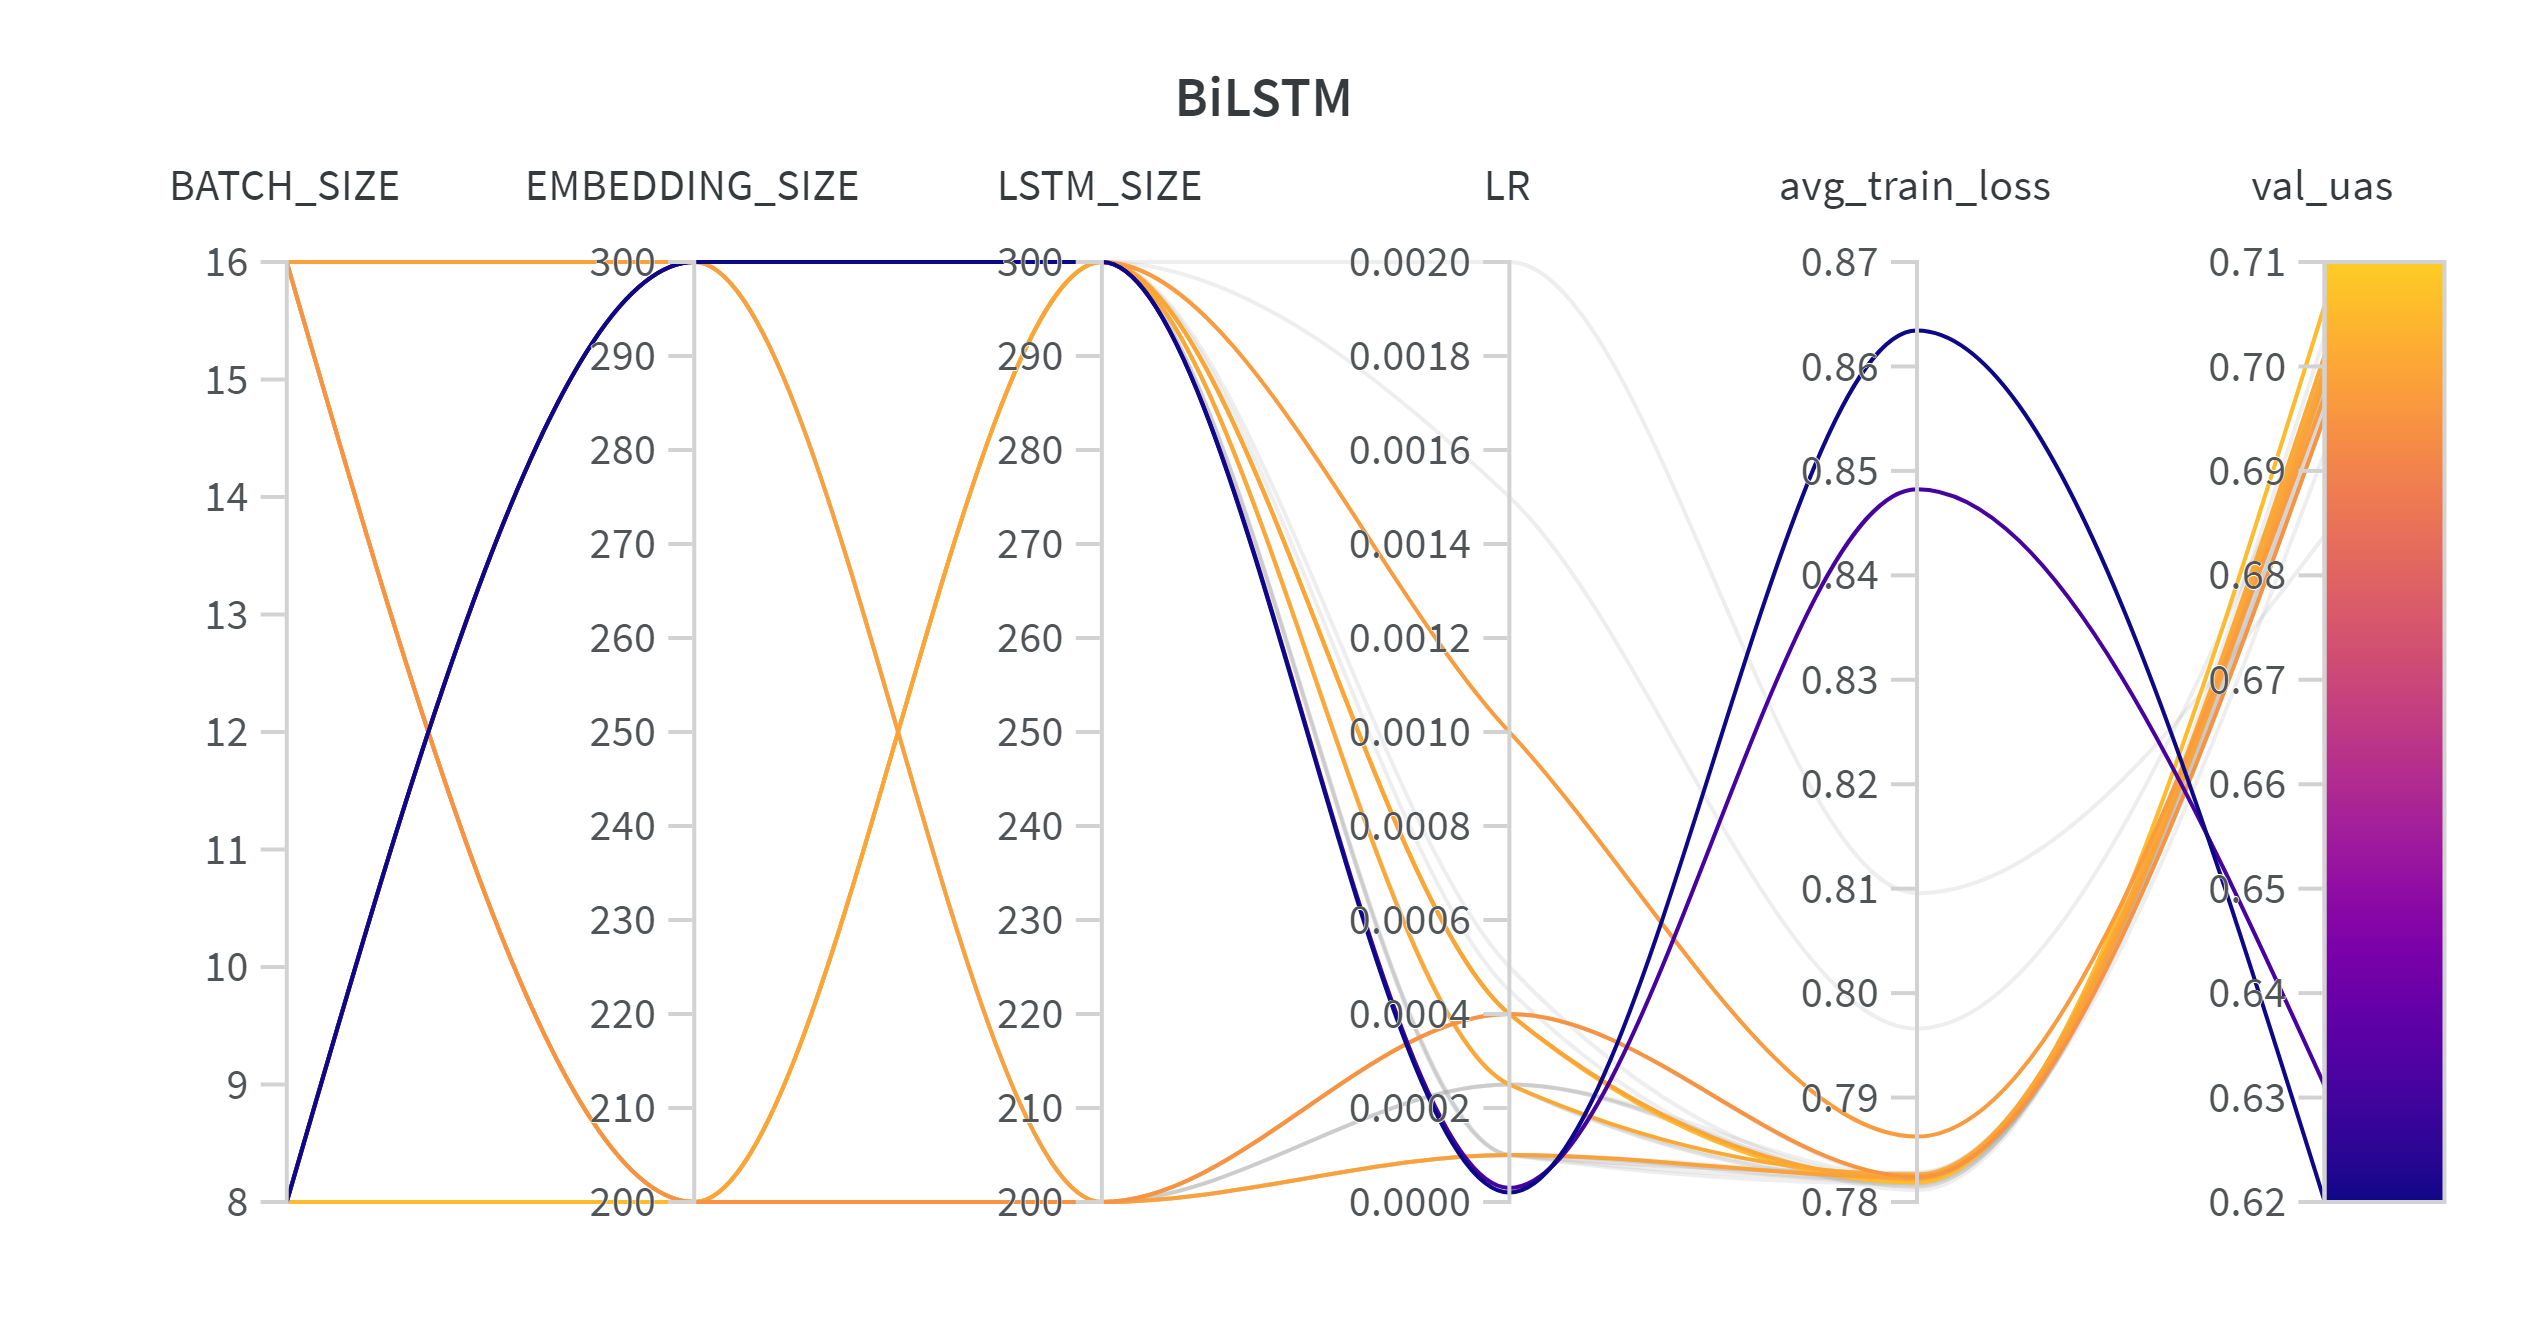

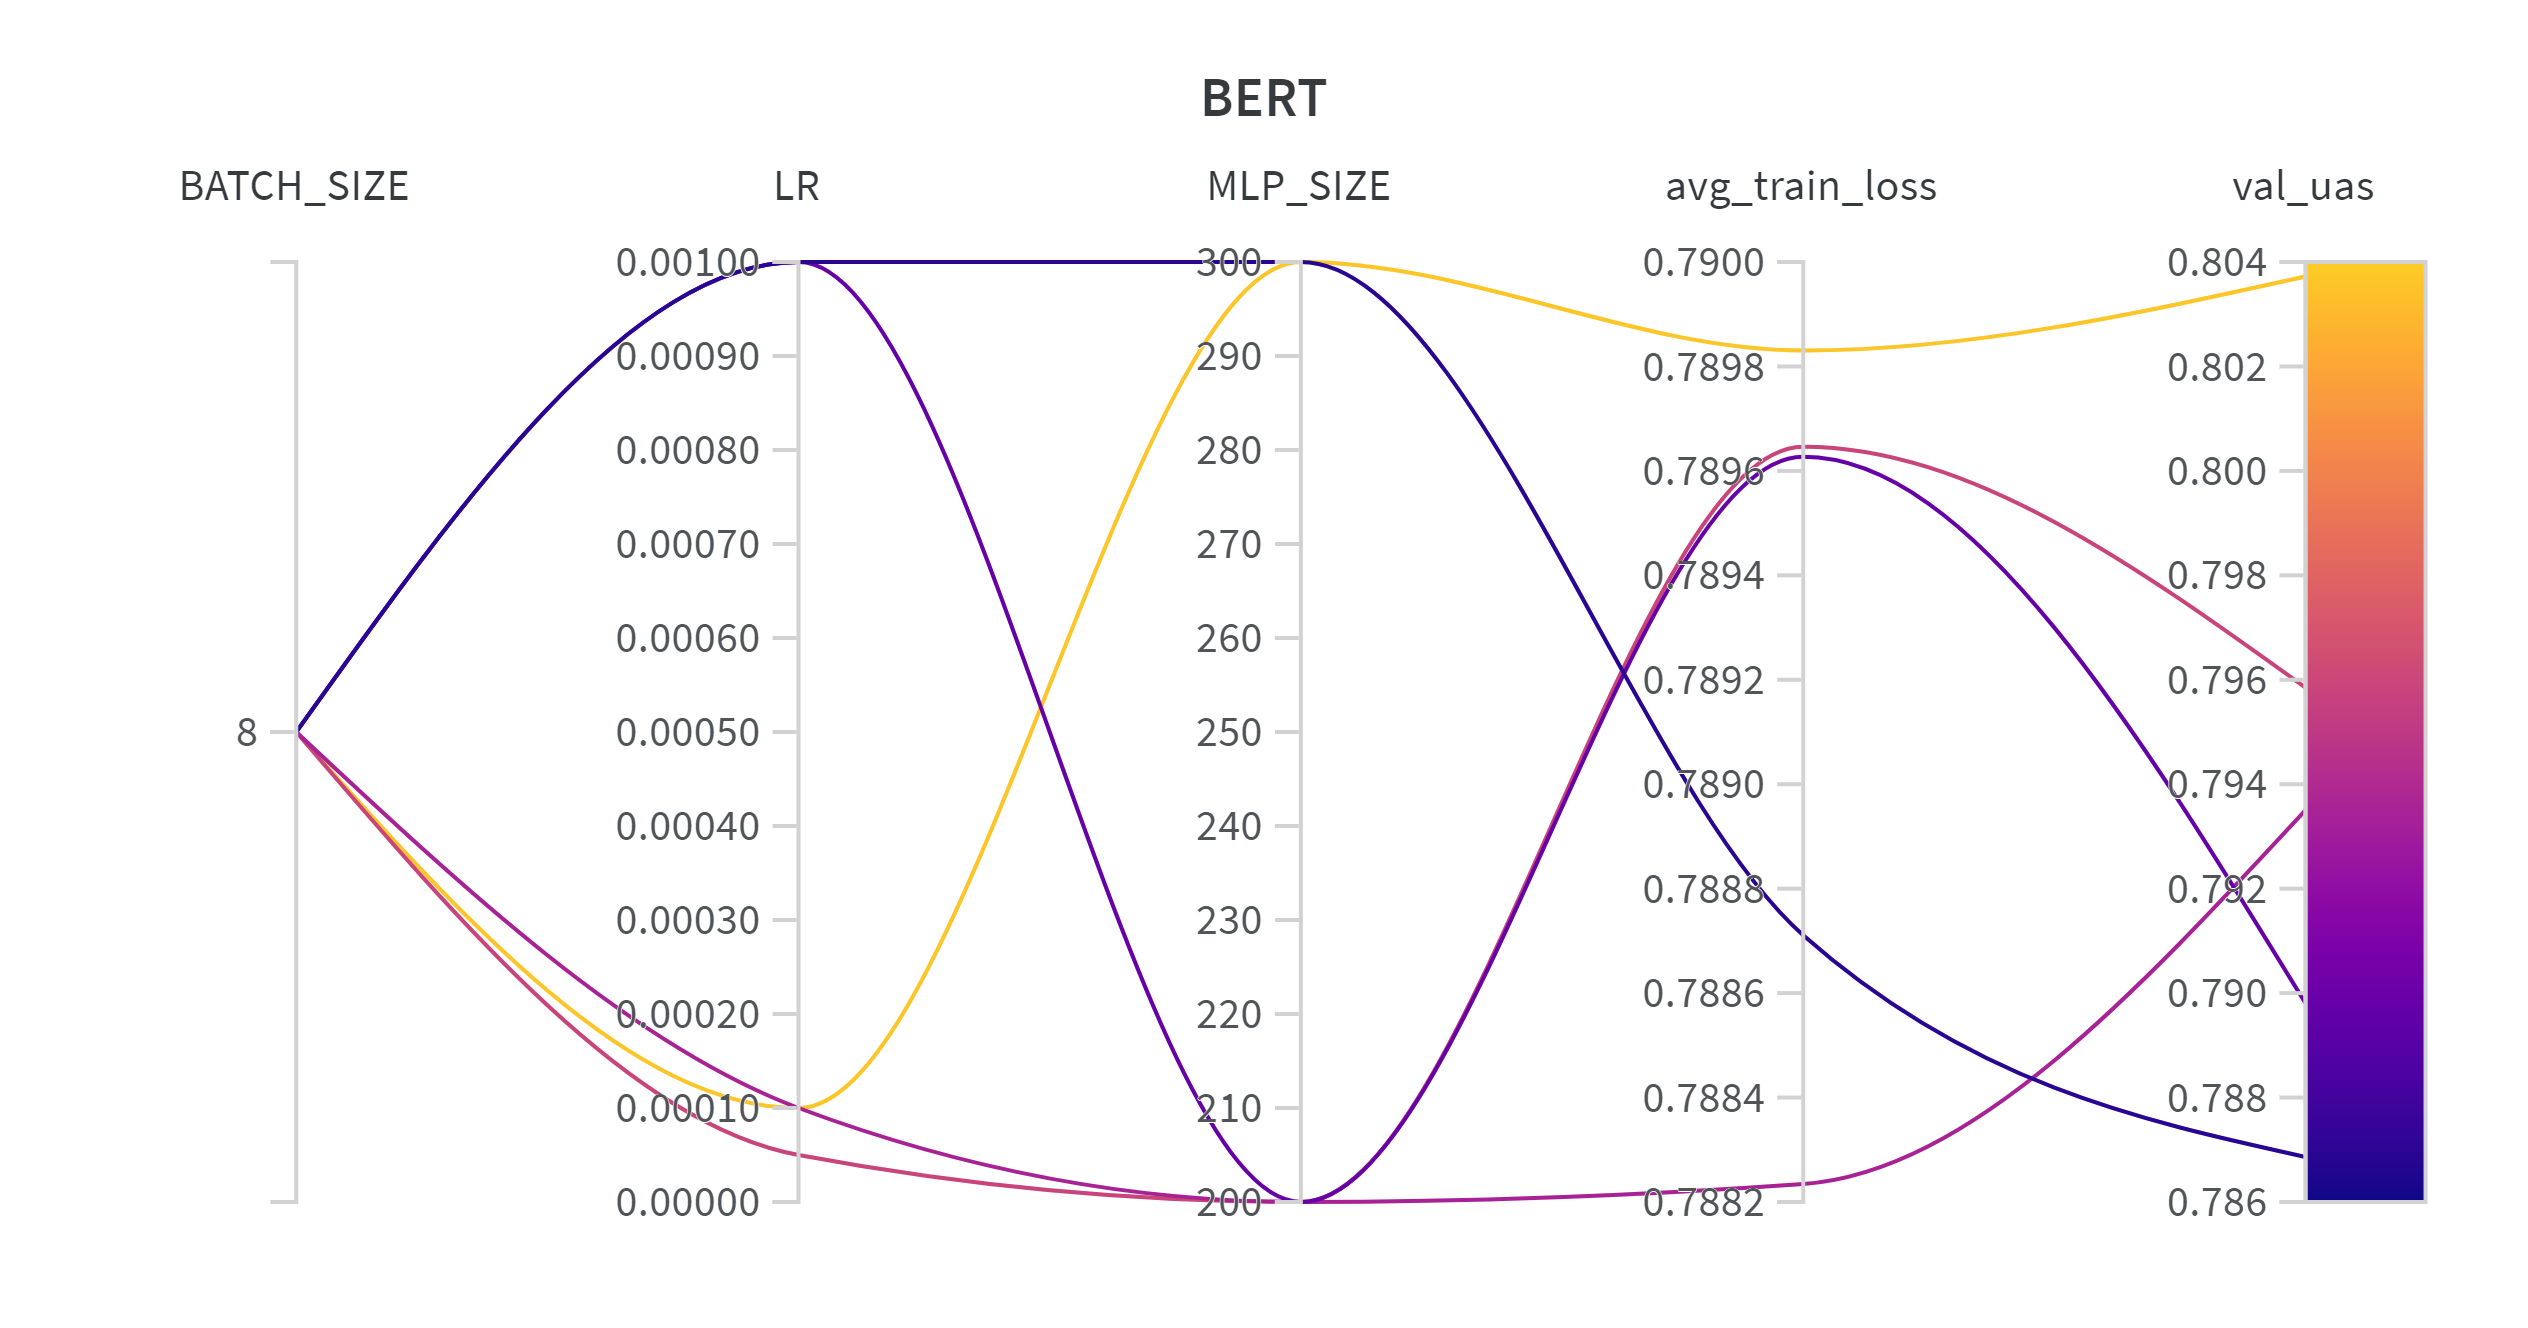

**N.B: The best scores were computed on 15 and 5 epochs for BiLSTM and BERT respectively.**

#BERT error analysis with sentence length distribution

The graph shows that the UAS score is low for very short sentences (<10 words) while it's more or less constant on longer sentences

As with the evaluation, the following graph is done on a single epoch of training but the analysis holds.

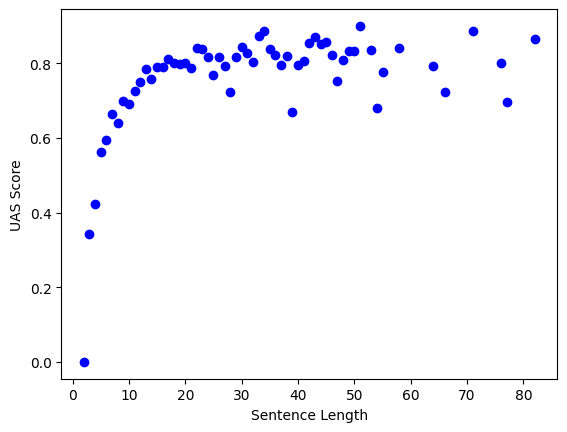

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def evaluate_len(gold, preds):
    total = 0
    correct = 0

    # Assume gold and preds are single lists, not lists of lists
    for i in range(1, len(gold)):
        total += 1
        if gold[i] == preds[i]:
            correct += 1

    return correct / total if total != 0 else 0

# Error analysis based on sentence length
sentence_lengths = [len(sentence) for batch in test_dataloader for sentence in batch[0]]
length_to_uas = defaultdict(list)

for i, batch in enumerate(test_dataloader):
    #print(f"Processing batch {i+1} of {len(test_dataloader)}")
    sentences, paths, moves, trees, input_ids , link, attention_mask = batch
    with torch.no_grad():
        try:
            pred_arcs = model_bert.infere(input_ids, sentences, link, attention_mask)

        except Exception as e:
            print("Error during inference: ", str(e))  # Print any errors during inference
            continue

        for sentence, gold_arcs, pred_arcs in zip(sentences, trees, pred_arcs):
            # Check if both gold_arcs and pred_arcs are lists
            if isinstance(gold_arcs, list) and isinstance(pred_arcs, list):
                # Calculate UAS score using your evaluate function
                uas_score = evaluate_len(gold_arcs, pred_arcs)

                # Append UAS score to list of scores for this sentence length
                length_to_uas[len(sentence)].append(uas_score)
            else:
                print(f"gold_arcs or pred_arcs is not a list: {gold_arcs}, {pred_arcs}")


# Calculate average UAS score for each sentence length
average_uas = {length: np.mean(uas_scores) for length, uas_scores in length_to_uas.items()}

# Sort by sentence length
sorted_uas = sorted(average_uas.items())

# Plot
plt.plot(*zip(*sorted_uas), 'bo')
plt.xlabel('Sentence Length')
plt.ylabel('UAS Score')
plt.show()

#BERT error analysis with confusion matrix

Confusion matrix to see when the actual operation is different from the gold one.  
Need to re-load the test dataloader with "get_gold_path= True" to get the gold moves.

As with the evaluation, the following graph is done on one epoch of training, the same trends hold.

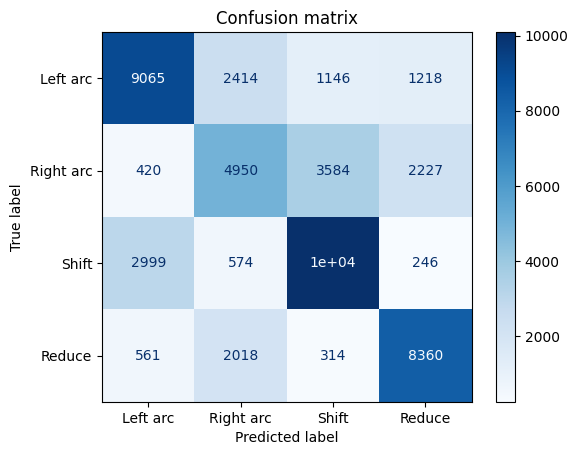

In [ ]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

operation_to_label = {"Left arc": 0, "Right arc": 1, "Shift": 2, "Reduce": 3}
# Reverse the dictionary to map labels to operations
label_to_operation = {v: k for k, v in operation_to_label.items()}
BATCH_SIZE=1 # easier
#load with gold moves
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert, get_gold_path=True))

cm = None


for i, batch in enumerate(test_dataloader):
    sentences, paths, gold_moves, trees, input_ids, link, attention_mask = batch

    new_cm = np.zeros((4, 4))
    new_cm = model_bert.compute_confusion_matrix(input_ids, sentences, link, attention_mask, gold_moves)
    if new_cm is not None:  # Check if inference was successful
        if cm is None:
            cm = new_cm
        else:
            cm += new_cm

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_to_operation.values())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()


#STATE OF THE ART COMPARISON

We base the first part of our discussion on the paper ["Improving the performance of graph based dependency parsing by guiding bi-affine layer with augmented global and local features"](https://www.sciencedirect.com/science/article/pii/S2667305323000157?ref=pdf_download&fr=RR-2&rr=7e72b8daaebd3744) by Mücahit Altıntas , A. Cüneyd Tantug.

The paper mainly focuses on multiple Turkish datasets but also analyses and compares the English EWT dataset, as well as Hungarian and Korean.


Part of table 4, where multiple models are evaluated with UAS on English EWT. Their base model is built by using pre-trained vectors and Bi-LSTM outputs, while the best results come using the "super token feature, which keeps the information about local collaborations, contributes to the parser for all evaluated languages more than sentence representation, which holds all sentence meanings"

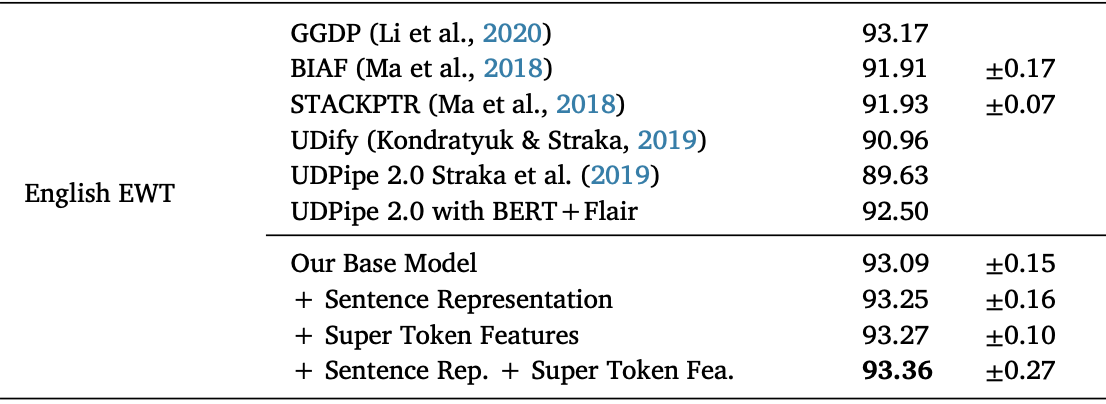

A second interesting paper is ["Evaluation of contextual embeddings on less-resourced languages"](https://www.researchgate.net/publication/353398910_Evaluation_of_contextual_embeddings_on_less-resourced_languages) by Matej Ulcar, Ales Zagar, Carlos S. Armendariz, Andraz Repar, Senja Pollak, Matthew Purver, Marko Robnik-Sikonja

The authors focus on many tasks with multiple languages, analyzing both monolingual and cross-lingual evaluation. The goal is to analyse it with a focus on less resourced languages. In this case they train the model on English and test on various languages; this analysis is not included in this notebook since it doesn't evaluate on the EWT dataset.

The ELMoForManyLangs (EFML) trained ELMo models on several languages but with relatively small datasets.

L-ELMo (Large-ELMo) models are made with the same architecture but trained on larger datasets (from 270 million to 5,5 billion words).

They also analyse multiple BERT architectures but they evaluate with LAS, so they are not included in this discussion.

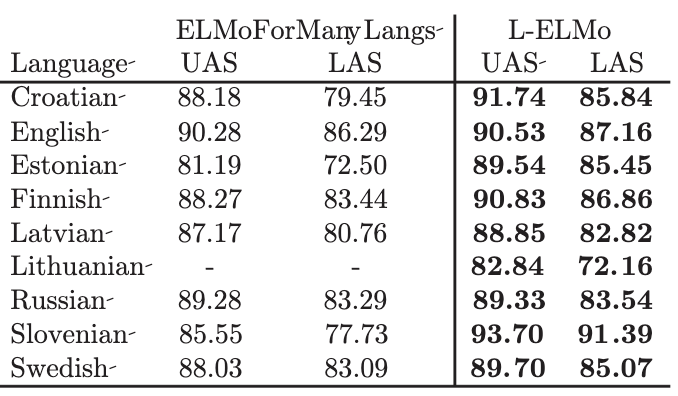